In [1]:
sys.path.insert(0, './common')

import sys
import wave
import a2c_model

c:\Users\nathan\AppData\Local\Programs\Python\Python310\lib\site-packages\tqdm\auto.py:22: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [2]:
env_path = 'velocity/Wave'

In [3]:
env = wave.WaveEnv(env_path)

WAVE environment created.


In [4]:
hidden_layer = 1024
model = a2c_model.A2C(64, 2, hidden_layer, lr=1e-4)

In [7]:
save_path = './results/velocity/newest_a2c'
model.set_model_save_path(save_path)

In [6]:
model.load_model()

Training history loaded
Model loaded


No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.


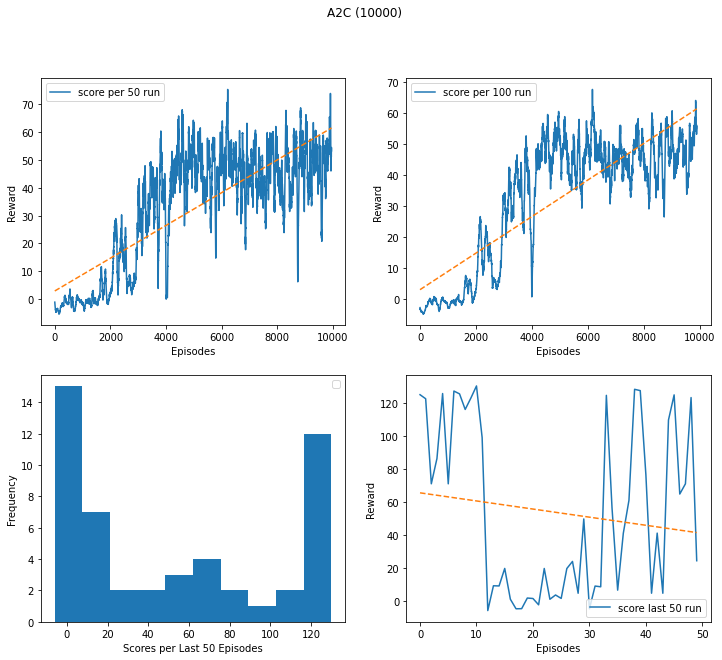

EPOCH: 9999, total reward: 24.19583210349083, timestep: 273


In [5]:
model.set_train_params(max_step=1000, plot_smooth=50)
model.train(env, 10000, show_plot=True)

In [8]:
model.save_model()

Training history saved


In [3]:
import saver
saver.save_wave_model(hidden_layer, f'{save_path}/actor.pth', f'{save_path}/model.onnx')

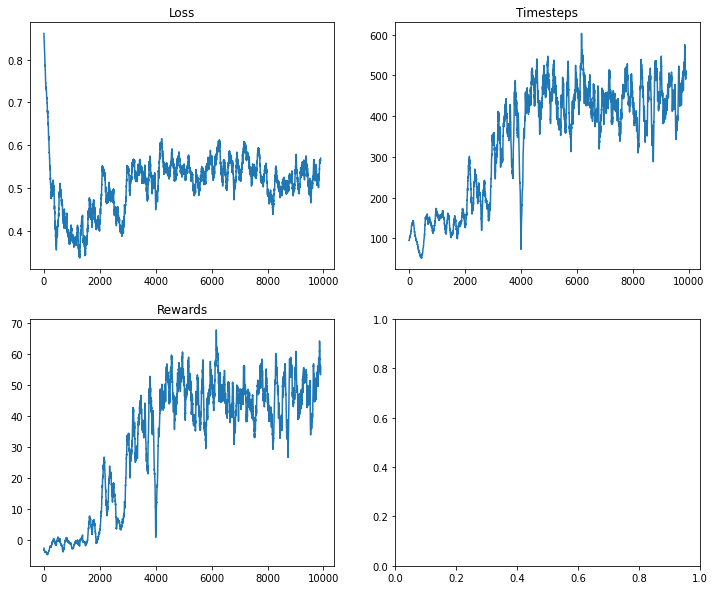

In [9]:
model.plot_train_memory(smooth=100)

In [11]:
env = wave.WaveEnv(env_path, 5)
model.test(env)

WAVE environment created.


(599.9302658811212, 4921)

In [18]:
model.test_avg(lambda time_scale: wave.WaveEnv(env_path, time_scale), 10, 40)

WAVE environment created.
WAVE environment created.
WAVE environment created.
WAVE environment created.
WAVE environment created.
WAVE environment created.
WAVE environment created.
WAVE environment created.
WAVE environment created.
WAVE environment created.


(11.060092589631676, 124.8)

In [7]:
env.close()